# Recommendation System Project

### What is a recommendation system?
The goal of a recommendation system is to surface recommendations that are relevant, novel, and fairly personalized to users of a platform. Recommenders are everywhere. Spotify "Discover Weekly", Netflix "Top Picks", recommended articles from a news provider, and product recommendations on your favorite ecommerce website are examples of recommendation systems. These systems can recommend songs, items, articles, and even people in the case of social media. For the remainder of this project, I will focus on recommending products in a retail setting, since that is my area of expertise. 

### Task
The task of a recommendation algorithm is to predict the item preferences of a user. Essentially, the algorithm predicts how a customer might "feel" about a product. This feeling or preference can be measured using an actual rating of an item (5/5 stars for example) or a relative ranking of top __n__ number of items in a list. 

### Benefits
There are many benefits to implementing a recommendation system, for both the organization and the customer. For the customer, recommendations can help reduce decision fatigue. If a business has tens, hundreds, or even thousands of options for a customer, it can be challenging to identify the "right" item. A business can utilize recommendation systems to reduce the number of presented choices and curate more relevant options for the user. This can improve customer experience by making the assortment easier to navigate and surfacing relevant items to the customer that they might not have found on their own.

For the business, this improved customer experience can lead to increased sales and even higher sell thru on products that a user might not find without the recommendation system.

### Types of Recommenders
There are many different types of recommendation systems. Two major categories are Content-Based and Collaborative-Filtering recommenders. Both utilize some form of user-item data that informs preferences about items that users have encountered before. 

__Content-Based Recommenders__<br>
These recommenders are based on the content or characteristics of the items being recommended. This can be taxonomy or hierarchy data, such as apparel or footwear. It can also be use case, product features, or other tags that describe the product. A common first pass at a recommender system is content-based, since it is fairly simple to implement. 

However, content-based recommenders have notable limitations. First, they require products to have content data readily available, which can be challenging in some cases. Second, they tend to recommend items to users that the user has likely already seen. By recommending items that are similar in content to an item that the user has already purchased, the recommender is not presenting the most relevant or novel items.

__Collaborative-Filtering Recommenders__<br>
These recommenders utilize the entire collection of user-item purchasing data to make recommendations. CF recommenders often leverage the similarity or hidden relationships between user preferences to estimate the preferences of specific users toward specific items. In this project, we will be focusing on collaborative filtering models of recommendation.

### Types of Preference Data
The two main categories of preference data used in recommender systems are implicit and explicit preference data.

__Explicit Preference Data__<br>
Explicit preference data refers most often to actual ratings that users give a product or item. This rating is typically a discrete range of numbers, but can be continuous. Explicit data can be valuable because it is direct feedback from a user that indicates their like or dislike for an item. However, explicit data is very sparse in many cases. Many customers might not rate a product they have purchased, or a movie they have watched. In general, having less data makes prediction more prone to error. Explicit data is also prone to bias, where ratings are skewed negative or positive for some reason. Most people have their own definition of "good" and where it lies on a rating scale. A 3 out of 5 can mean different things to different people. 

__Implicit Preference Data__<br>
Implicit preference data refers to features or metrics that indirectly indicate the preferences of a user. The user is not explicitly rating the product or item, but their behavior can help us understand how they might feel about the product. Implicit data can be clicks on a webpage, time spent on page, add to cart actions, purchases, and more. Each of these examples of implicit data have advantages and drawbacks. 

In this project, we will focus on purchases of items. If a customer purchases an item, it is a fairly safe assumption that they like the product to a certain extent. It is of course possible to buy a product and then realize it does not meet your needs as a customer. We will address the nuances of our implicit data more in the data preparation section of this project.

### Project Goal
The goal of this project is to explore a popular algorithm for recommendation systems, evaluating its performance on ecommerce data from UC Irvine's Machine Learning Repository.

### Project Outline
1. Get the Data
1. Data Cleaning
1. Feature Engineering (Implicit Preference Data)
1. Transform the Data into User-Item Matrix
1. Selecting the Model
1. Optimizing Model Parameters
1. Training the Model
1. Evaluating the Model
1. Conclusion & Next Steps

__Citation for Dataset__ <br>
Chen,Daqing. (2019). Online Retail II. UCI Machine Learning Repository.<br>
https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii

### Get the Data

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import kdeplot
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import recmetrics

In [2]:
# reading in both tabs of dataset
dataset = pd.read_excel(r'C:\Users\bwynd\OneDrive\Desktop\Data Analysis Portfolio\online_retail_data.xlsx',[0,1])

In [3]:
# merging both tabs into one dataframe
df = pd.concat(dataset, ignore_index=True)

In [4]:
# getting an idea of the data
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,924,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,2824,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,2895,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,529,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,214,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,416,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,3218,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,3234,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,2352,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


### Cleaning the Data

Now that we have loaded the data, we will need to clean and transform the data in order to get the best results.

By calling df.info(), we can see in the Customer ID and Description columns we have a significant number of null rows.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  int64         
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 65.1+ MB


On closer inspection, we can see that the null values in Description are noise and can be dropped. All items have a price of 0 and have no Customer ID.

It is not always a good practice to drop null records. Sometimes it is better to impute the values, where null values are replaced with the mean, median, or mode. In this case, dropping null records is the better option.

In a true business setting, this noise in the dataset is important to understand. The wide range in Quantity is concerning and could impact other metrics or reporting. This noise could be caused by errors in the data, wholesale purchases by other organizations, or processes that impact records in an unintended manner (inventory adjustments in/out, zero dollar sales, etc).

Since we do not have the ability to investigate the causes behind this dataset, we will remove these rows.

In [6]:
df[df['Description'].isna()].describe()

,StockCode,Quantity,Price,Customer ID
count,4382.000000,4382.000000,4382.0,0.0
mean,2793.217252,-17.262209,0.0,NaN
std,1543.331163,509.704959,0.0,NaN
min,3.000000,-9600.000000,0.0,NaN
25%,1486.250000,-28.000000,0.0,NaN
50%,2897.500000,-4.000000,0.0,NaN
75%,4242.000000,3.000000,0.0,NaN
max,5129.000000,9600.000000,0.0,NaN


In [7]:
# dropping all null values in Description column
df.dropna(axis=0,subset=['Description'],inplace=True)

The null customer values will need to be removed as well, since our Recommendation System algorithm relies on customer ids to function properly. These missing customer ids could be guest customers or other transactions. 

The model we will be implementing does not make predictions for guest customers. This is a limitation that I will address in the conclusion section.

In [8]:
df[df['Customer ID'].isna()].describe()

,StockCode,Quantity,Price,Customer ID
count,238625.000000,238625.000000,238625.000000,0.0
mean,1240.684312,1.885833,8.094711,NaN
std,1076.534535,71.946304,226.322727,NaN
min,1.000000,-9600.000000,-53594.360000,NaN
25%,374.000000,1.000000,1.660000,NaN
50%,954.000000,1.000000,3.360000,NaN
75%,1767.000000,2.000000,5.790000,NaN
max,5132.000000,10200.000000,25111.090000,NaN


In [9]:
# dropping all null values in Customer ID column
df.dropna(axis=0,subset=['Customer ID'],inplace=True)

Now we can see that all columns have the same number of records, and all null records have been removed. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  int64         
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  float64       
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 56.6+ MB


While exploring the data, we see that there are negative quantities and $0.00 price values in the set. This is noise data for our analysis, since it indicates some kind of return, receipt, or 0 dollar sale. 

We will remove all rows that fit either condition. 

In [11]:
# removing all rows with quantity <= 0
df.drop(df[df['Quantity']<=0].index,inplace=True)

In [12]:
# removing all rows with price <= 0
df.drop(df[df['Price']<=0].index,inplace=True)

In [13]:
df.describe()

,StockCode,Quantity,Price,Customer ID
count,805549.000000,805549.000000,805549.000000,805549.000000
mean,1222.573430,13.290522,3.206561,15331.954970
std,1161.013427,143.634088,29.199173,1696.737039
min,1.000000,1.000000,0.001000,12346.000000
25%,293.000000,2.000000,1.250000,13982.000000
50%,817.000000,5.000000,1.950000,15271.000000
75%,1773.000000,12.000000,3.750000,16805.000000
max,5128.000000,80995.000000,10953.500000,18287.000000


### Preparing the Data / Feature Engineering

Now we will move on to preparing the data for the recommendation algorithm.

- Create numeric columns for product_id and cust_id
- Create some column that quantifies user preference for an item

First, we need to create columns for numeric product and customer ids. This is necessary for the algorithm we are using.

In [14]:
# create columns for cust_id and product_id, need unique numeric values for matrix
df['cust_id'] = df.groupby(['Customer ID']).ngroup()
df['product_id'] = df.groupby(['StockCode']).ngroup()

Next we need to quantify user preference for the items they have purchased in this dataset. 

Quantity by itself is not always the most meaningful metric to measure how a user "ranks" the product. If we measure the ranking of our user-product matrix based on simple quantity, we may end up recommending users mostly cheap add-on products, rather than the most meaningful products. 

While there are likely many ways to estimate a users ranking of a product, in this project we will simply __multiply price by quantity.__ 

By multiplying the quantity and price together, we get a simple measure of a customer's "rank" or desire to purchase the product. This idea is built on the assumption that a customer would generally like to minimize money spent and maximize the "value" gained from a purchase. 

If they are buying more units of a higher price item, there is a good chance that they have strong positive feelings toward that product. If a customer buys large quantities of a cheaper item and small quantities of a more expensive item, those items might be "ranked" similarly because of the combination of price and quantity. 

While this feature has some assumptions that could be fine tuned, it will be a good starting point for this recommender system.

We will name this column 'rating' for the sake of simplicity, even though it is not an explicit rating from the customer. 

In [15]:
# create new col 'rating'
df['rating'] = df['Quantity'] * df['Price']

In [16]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cust_id,product_id,rating
0,489434,924,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,735,923,83.40
1,489434,2824,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,735,2803,81.00
2,489434,2895,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,735,2874,81.00
3,489434,529,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,735,528,100.80
4,489434,214,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,735,213,30.00
...,...,...,...,...,...,...,...,...,...,...,...
1067366,581587,416,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,333,415,12.60
1067367,581587,3218,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,333,3184,16.60
1067368,581587,3234,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,333,3200,16.60
1067369,581587,2352,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,333,2343,14.85


Now that we have created our 'rating' column, let's look at the distribution of values in the feature.

In [17]:
df.max()

Invoice                                  581587
StockCode                                  5128
Description    ZINC WIRE SWEETHEART LETTER TRAY
Quantity                                  80995
InvoiceDate                 2011-12-09 12:50:00
Price                                   10953.5
Customer ID                             18287.0
Country                             West Indies
cust_id                                    5877
product_id                                 4630
rating                                 168469.6
dtype: object

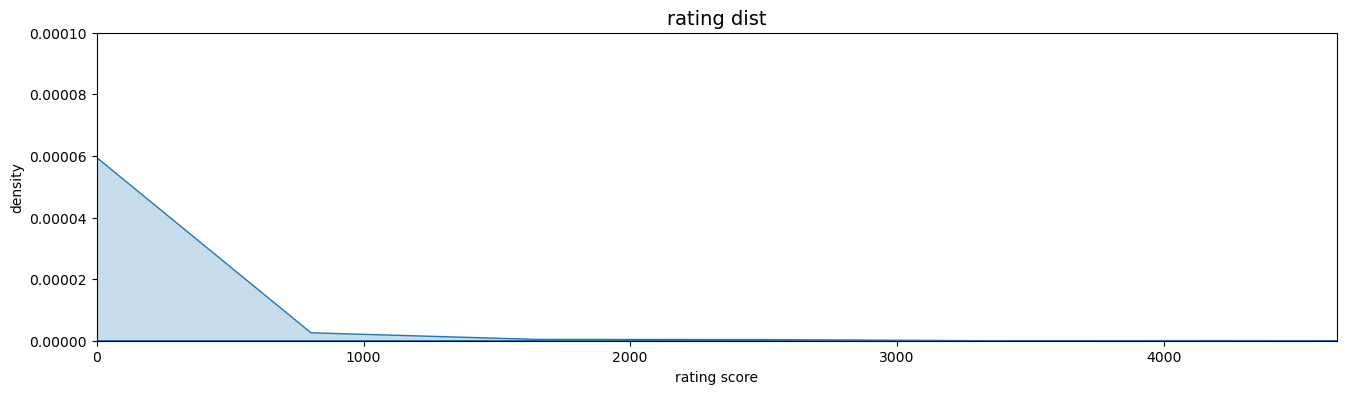

In [18]:
# plot the distribution of rows by rating value
# higher density = more rows/records with that rating value
plt.figure(figsize=(16,4))
sns.kdeplot(df['rating'], shade=True)
plt.xlim(0,4650)
plt.ylim(0,0.0001)
plt.title("rating dist", fontsize=14)
plt.xlabel("rating score")
plt.ylabel("density")
plt.show()

Looking at the distribution of rating values in the data, there is a very long tail to the right. This tail makes up 3% of the total data, indicating that rating values over 50 are likely outliers. 

These outliers could be generated by wholesale purchases or other large movements of inventory that do not apply to the typical customer. As a result, we will remove these records. If left in, these outliers could skew the recommendations. 

In [19]:
# removing clear outliers, 97% of records fall under a rating score of 50
df[df.rating <= 50]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cust_id,product_id,rating
4,489434,214,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,735,213,30.00
5,489434,215,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,735,214,39.60
6,489434,50,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,735,49,30.00
8,489435,1231,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,735,1229,30.60
9,489435,200,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,735,199,45.00
...,...,...,...,...,...,...,...,...,...,...,...
1067366,581587,416,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,333,415,12.60
1067367,581587,3218,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,333,3184,16.60
1067368,581587,3234,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,333,3200,16.60
1067369,581587,2352,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,333,2343,14.85


In [20]:
df = df[df.rating <= 50]

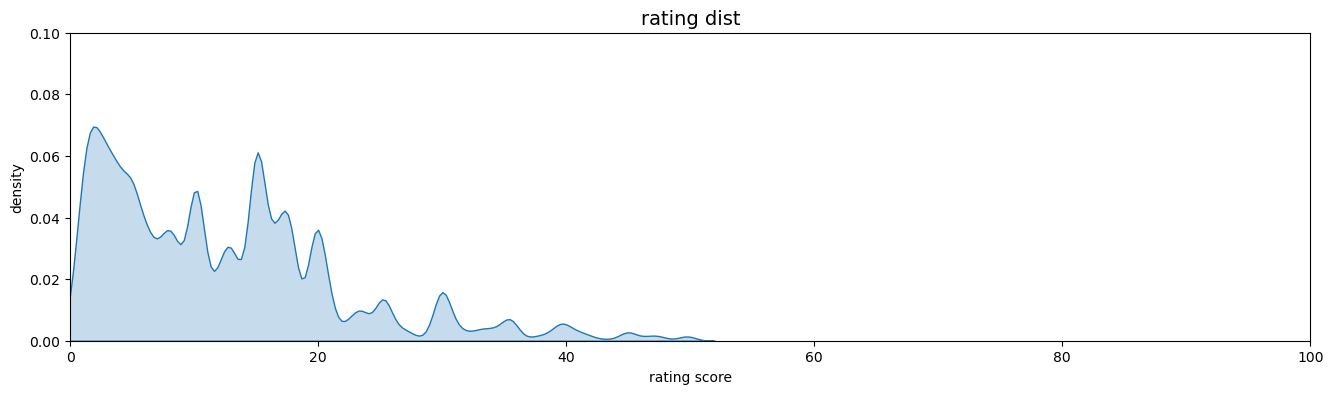

In [21]:
plt.figure(figsize=(16,4))
sns.kdeplot(df['rating'], shade=True)
plt.xlim(0,100)
plt.ylim(0,0.1)
plt.title("rating dist", fontsize=14)
plt.xlabel("rating score")
plt.ylabel("density")
plt.show()

### Transform the Data into a User-Item Matrix

__User Item Matrices__<br>
The model we explore below requires that we transform our transaction data into a user-item matrix, with users as the columns and items as the rows. The values in each "cell" refer to the "rating" for that user-item pair. 

For example, the "rating" that user_1 has indicated for product_a is 20.

This type of matrix is typically sparse, meaning that most of the "cells" in the matrix are empty. This is because most users have not encountered, purchased, or rated every item.

The task of the model in this project is to somehow fill in these empty user-item pairs, estimating the rating that a user might give to the item in question.


||User_1| User_2 | User_3 | User_4 |
| --- | --- | --- | --- | --- |
|Product_A| 20 |  | 15 | 4
|Product_B| 10 | 30 | 15 | 22
|Product_C|   | 3 | 40 |
|Product_D| 10 | 50 | 15 |

In [22]:
reader = Reader(rating_scale=(0, 100))

In [23]:
data = Dataset.load_from_df(df[["cust_id", "product_id", "rating"]], reader)

### Selecting the Model

There are many different approaches to collaborative filtering recommendation problems. One algorithm, made popular by the Netflix Prize Recommendation Challenge, is the FunkSVD algorithm by Simon Funk. It is famous for its performance in the challenge, as well as the fact that Simon Funk made the algorithm public. 

While this algorithm may share a name with SVD, Singular Value Decomposition, the similarities between the two machine learning techniques are minimal.

The FunkSVD algorithm factorizes the user-item matrix into two factor matrices. The two factor matrices are then combined, resulting in an estimation of the original matrix with the empty values filled in. These filled in values are our predictions.

I explain in more detail below. 

__Algorithm Steps:__
1. Create two factor matrices, one for user factors U and one for item factors V^T.
1. Fill the factor matrices with random numbers to start.
1. Search User-Item matrix for a user item pair with a rating value that we know.
1. Get the random factor values for that user item pair.
1. Compute the dot product, this is the predicted rating.
    - (User-Factor 1 x Item-Factor 1) + (User-Factor 2 x Item-Factor 2) + ... + (User-Factor n x Item-Factor m)
1. Compute the error between the actual rating and the predicted rating
1. Minimize the error using Gradient Descent
    - Gradient Descent is an optimization algorithm used in machine learning and neural networks
    - Since our original factors are random, the error will be large at the start. The goal of Gradient Descent is to move towards a "lowest point" in our error.
    - It is commonly explained as a ball rolling down a hill, we compute the "slope" and "direction" toward the lowest error and change the factors to move toward that lowest error
    - A good explanation from 3Blue1Brown can be found here -- https://youtu.be/IHZwWFHWa-w
1. Replace the new factor values (identified through gradient descent) in the U and V^T matrices
1. Repeat this process until the error is minimized
1. Repeat this process for all known user-item pairs

__Original User - Item Matrix__<br>

||User_1| User_2 | User_3 | User_4 |
| --- | --- | --- | --- | --- |
|Product_A| 20 |  | 15 | 4
|Product_B| 10 | 30 | 15 | 22
|Product_C|   | 3 | 40 |
|Product_D| 10 | 50 | 15 |


__User Factor Matrix - Initialized with Random Values__

||User_1| User_2 | User_3 | User_4 |
| --- | --- | --- | --- | --- |
|Factor_1| 0.8 | 1 | 1.2 | -0.1
|Factor_2| 3 | 3 | 1.4 | 0.6
|Factor_3| -0.2 | 0.1 | 4 | 2.3

__Item Factor Matrix - Initialized with Random Values__

||Factor_1| Factor_2 | Factor_3 |
| --- | --- | --- | --- |
|Product_A| 2 | 1 | -0.3 |
|Product_B| 0.1 | 1.2 | 4 |
|Product_C| 0.5  | 0.01 | 0.6 |
|Product_D|  3 | -0.4 | 5 |

Once the error has been minimized and the factor matrices have been optimized, we can use the user factors and item factors to predict missing values in the original matrix. 

Each prediction is made by computing the dot product of the user-item factors for the user-item pair we are predicting.

__Documentation__<br>
https://surprise.readthedocs.io/en/stable/matrix_factorization.html

### Optimizing Model Parameters

Now that we have selected a model and transformed our data into a user-item matrix, we need to optimize our model parameters.

Model parameters impact different aspects of the algorithm, such as regularization, learning rate, number of iterations, and number of factors. These parameters impact the performance of the algorithm in different ways, so it is important for us to find the best parameters for our data. 

__Regularization__: <br>
Common technique that discourages the machine learning algorithm from learning a complex model. Complex models are prone to overfitting to training data, which makes them fail at generalizing to new data.

__Learning Rate__:<br>
Controls how "quickly" the optimization algorithm converges or descends on a minimum error. There are tradeoffs to high and low learning rates.

__Number of Factors__:<br>
The number of factors that are computed for the U and V^T matrices.

__Number of Iterations__:<br>
The number of times the data is run through the learning algorithm. Eventually, the error will level out, so optimizing the number of iterations can improve model speed.


To do this, we will use GridSearch from the surprise library, which iterates through all of the parameter options we set and returns the group of parameters that obtained the lowest error. 

We have set cv (cross validate) to 5, which will create 5 folds (sets). Each set is used once as a test set, while the others are used as training sets. This helps minimize overfitting while finding the optimal parameters. 

Once GridSearchCV has determined the optimal params, we will use these when we create our model.

In [24]:
from surprise.model_selection import GridSearchCV

In [25]:
param_grid = {"n_factors": {100}, "n_epochs": [10, 20, 30], "lr_all": [0.003, 0.004, 0.005], 
              "reg_all": [0.01, 0.02, 0.03]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

6.3230262946508295
{'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.003, 'reg_all': 0.03}


### Train Test Split

Now that we have optimized our model parameters, we can split the data into a training set and testing set. The model will be trained on the training set, and then evaluated on the test set. 

The purpose of the test set is to simulate how the model might perform in the real world, on data it has not seen before.

In [58]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

### Training the Model

In [59]:
model = SVD(n_factors=100,n_epochs=10,lr_all=0.003,reg_all=0.03)

In [60]:
# fitting the training data
# this is where the algo creates the factor matrices and optimizes the factors using gradient descent
model.fit(trainset)

### Make Predictions on the Test Set

In [61]:
# make predictions using the optimized factors, for each user-item pair in the test set
svd_pred = model.test(testset)

In [62]:
# read the predictions into a pandas dataframe, so that we can view them
svd_pred_df = pd.DataFrame(svd_pred)

In [63]:
# compute the root mean squared error
accuracy.rmse(svd_pred)

RMSE: 6.3408


6.3407967075682095

In [64]:
svd_pred_df

,uid,iid,r_ui,est,details
0,2629,359,4.16,3.838576,{'was_impossible': False}
1,5669,694,39.60,35.774401,{'was_impossible': False}
2,5328,892,12.50,15.445086,{'was_impossible': False}
3,5626,14,2.10,4.036804,{'was_impossible': False}
4,790,175,17.85,14.788617,{'was_impossible': False}
...,...,...,...,...,...
187345,3908,22,17.85,17.870361,{'was_impossible': False}
187346,2360,589,2.50,2.104825,{'was_impossible': False}
187347,1961,1430,12.70,23.156676,{'was_impossible': False}
187348,5369,357,0.39,1.384897,{'was_impossible': False}


### Evaluating the Model

Above, we have computed the Root Mean Squared Error (RMSE) for our instance of the FunkSVD algorithm. RMSE is a valuable tool in measuring how far the predictions are from the actuals, across the entire test set. 

In the case of recommender systems, however, RMSE is not the only evaluation measure we want to use.

In a recommender system, we are unlikely to present all possible items to a user. That would, in a sense, defeat the purpose of the system. More often than not, we will want to present a top-N number of items to a user. The value of N depends on how many items we want to surface to the user. This can be decided using a number of factors: how many items we can fit on the webpage, what is the best number of items to present based on A/B testing, etc. In this notebook, we will select the top 10 items for each user. 

Since we are not concerned with the entire set of possible user-item pairs anymore, we will focus on evaluating how well the system predicts the top 10 items.

The top 10 items are selected by ordering the predicted user-item ratings from greatest to least and taking the top 10. 

There is a rich collection of different methods for evaluating a recommender system.

Here are the methods we will utilize in this section of the notebook:
- Recall
    - Proportion of relevant recommended items to total relevant items
- Precision
    - Proportion of relevant recommended items to total recommended items
- Coverage
    - % of items in the training set that the model recommended to the test users
    - There is great value in a recommender that can surface relevant recommendations to the user, while also capturing a good portion of the total item assortment in its recommendations. A lower coverage score means that many products will never be recommended to a user.
- Personalization
    - Measures how similar each user's recommendations are to each other.
    - A good recommender algorithm should be should have a high personalization score, since users tend to have different preferences.
    
We will compare the FunkSVD algorithm to Random and Popularity based recommendations as a baseline. If the model does not outperform both algorithms on Recall and Precision, other algorithms should be explored.
    
Metrics from https://github.com/statisticianinstilettos/recmetrics

In [65]:
#create model (matrix of predicted values)
svd_model = svd_pred_df.pivot_table(index='uid', columns='iid', values='est').fillna(0)

In [66]:
svd_model

iid,0,1,2,3,4,5,6,7,8,9,...,4615,4616,4617,4618,4620,4621,4622,4623,4624,4628
uid,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,6.510315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5874,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [68]:
comp_df = svd_pred_df.copy().groupby('uid', as_index=False)['iid'].agg({'r_ui': (lambda x: list(set(x)))})

In [69]:
comp_df

,uid,r_ui
0,0,"[896, 24, 4451, 1981]"
1,1,"[640, 1027, 3332, 1283, 3852, 269, 18, 1043, 5..."
2,2,"[1729, 289, 291, 966, 71, 72, 844, 45, 495, 16..."
3,3,"[1410, 1667, 130, 1415, 778, 271, 3471, 1296, ..."
4,4,"[324, 1127, 426, 2160, 1785, 831]"
...,...,...
5475,5873,"[0, 517, 3589, 521, 3597, 3598, 15, 3600, 18, ..."
5476,5874,"[682, 661, 1606]"
5477,5875,"[1020, 1999]"
5478,5876,"[897, 1157, 4113, 532, 406, 1054, 2596, 422, 4..."


In [70]:
comp_df = comp_df.set_index("uid")

In [71]:
svd_recs = [] = []
for user in comp_df.index:
    svd_predictions = get_users_predictions(user, 10, svd_model)
    svd_recs.append(svd_predictions)
        
comp_df['svd_predictions'] = svd_recs
comp_df.head()

,r_ui,svd_predictions
uid,,
0,"[896, 24, 4451, 1981]","[4451, 1981, 24, 896, 2951, 2952, 2954, 2955, ..."
1,"[640, 1027, 3332, 1283, 3852, 269, 18, 1043, 5...","[532, 1141, 1435, 694, 317, 2356, 640, 18, 44,..."
2,"[1729, 289, 291, 966, 71, 72, 844, 45, 495, 16...","[291, 45, 1729, 966, 698, 844, 1652, 495, 289,..."
3,"[1410, 1667, 130, 1415, 778, 271, 3471, 1296, ...","[532, 1016, 1619, 1981, 271, 130, 158, 2249, 1..."
4,"[324, 1127, 426, 2160, 1785, 831]","[426, 2160, 324, 1127, 831, 1785, 2958, 2949, ..."


### Popularity Recommendation

In [72]:
# select most popular items, ranked by their number of appearances in the dataaset
# this model recommends the top 10 items to all users
popularity_recs = df.product_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in comp_df.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
comp_df['pop_predictions'] = pop_recs
comp_df.head()

,r_ui,svd_predictions,pop_predictions
uid,,,
0,"[896, 24, 4451, 1981]","[4451, 1981, 24, 896, 2951, 2952, 2954, 2955, ...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]"
1,"[640, 1027, 3332, 1283, 3852, 269, 18, 1043, 5...","[532, 1141, 1435, 694, 317, 2356, 640, 18, 44,...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]"
2,"[1729, 289, 291, 966, 71, 72, 844, 45, 495, 16...","[291, 45, 1729, 966, 698, 844, 1652, 495, 289,...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]"
3,"[1410, 1667, 130, 1415, 778, 271, 3471, 1296, ...","[532, 1016, 1619, 1981, 271, 130, 158, 2249, 1...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]"
4,"[324, 1127, 426, 2160, 1785, 831]","[426, 2160, 324, 1127, 831, 1785, 2958, 2949, ...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]"


### Random Recommendation

In [73]:
# random recommendations to all users
ran_recs = []
for user in comp_df.index:
    random_predictions = df.product_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
comp_df['random_predictions'] = ran_recs
comp_df.head()

,r_ui,svd_predictions,pop_predictions,random_predictions
uid,,,,
0,"[896, 24, 4451, 1981]","[4451, 1981, 24, 896, 2951, 2952, 2954, 2955, ...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]","[1256, 72, 717, 1566, 1573, 26, 4041, 4042, 32..."
1,"[640, 1027, 3332, 1283, 3852, 269, 18, 1043, 5...","[532, 1141, 1435, 694, 317, 2356, 640, 18, 44,...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]","[638, 4189, 621, 69, 1014, 1129, 290, 2461, 36..."
2,"[1729, 289, 291, 966, 71, 72, 844, 45, 495, 16...","[291, 45, 1729, 966, 698, 844, 1652, 495, 289,...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]","[351, 3376, 1620, 481, 420, 85, 3311, 513, 113..."
3,"[1410, 1667, 130, 1415, 778, 271, 3471, 1296, ...","[532, 1016, 1619, 1981, 271, 130, 158, 2249, 1...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]","[714, 3497, 651, 293, 483, 2102, 52, 1378, 609..."
4,"[324, 1127, 426, 2160, 1785, 831]","[426, 2160, 324, 1127, 831, 1785, 2958, 2949, ...","[0, 140, 66, 69, 13, 382, 532, 294, 292, 264]","[1265, 186, 55, 328, 234, 3648, 100, 1652, 188..."


### Measuring Mean Average Recall @ K

Recall measures the proportion of relevant recommended items to the total number of relevant items. K is the number of recommended items.

Formula for Recall @ K:
(# of relevant recommended items @ k)/(total number of relevant items)

Do this for all users and get the mean.

In [74]:
actual = comp_df.r_ui.values.tolist()
svd_predictions = comp_df.svd_predictions.values.tolist()
pop_predictions = comp_df.pop_predictions.values.tolist()
random_predictions = comp_df.random_predictions.values.tolist()

In [75]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])

In [76]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])

In [77]:
svd_mark = []
for K in np.arange(1, 11):
    svd_mark.extend([recmetrics.mark(actual, svd_predictions, k=K)])

The Popularity and Random Recommenders perform poorly on MAR@K, while the FunkSVD Recommender performs fairly well. 

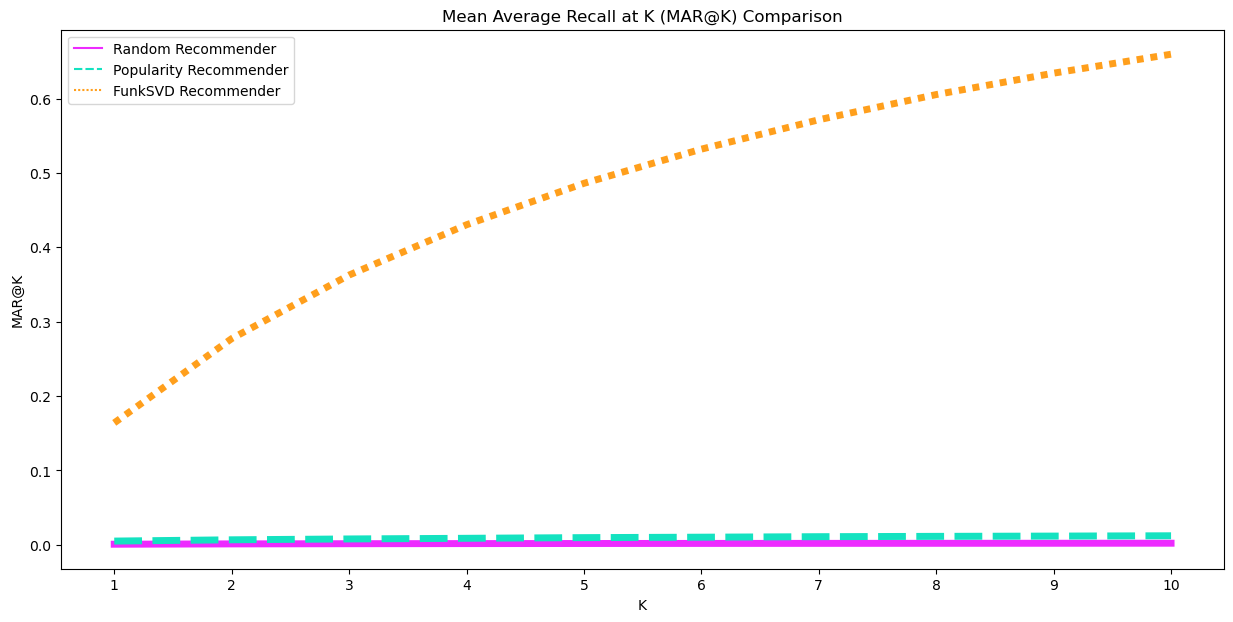

In [78]:
mark_scores = [random_mark, pop_mark, svd_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'FunkSVD Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

### Mean Average Precision @ K

Precision measures the proportion of relevant recommended items to the total number of recommended items for that user. K is the number of recommended items. 

Formula for Precision @ K: (# of relevant recommended items @ k)/(number of items recommended to user)

Do this for all users and get the mean. 

In [79]:
# functions from ml_metrics https://github.com/benhamner/Metrics
def mapk(actual,predicted,k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def apk(actual,predicted,k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [80]:
pop_mapk = []
for K in np.arange(1, 11):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])

In [81]:
random_mapk = []
for K in np.arange(1, 11):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])

In [82]:
svd_mapk = []
for K in np.arange(1, 11):
    svd_mapk.extend([mapk(actual, svd_predictions, k=K)])

FunkSVD Recommender again outperforms the Random and Popularity Recommenders.

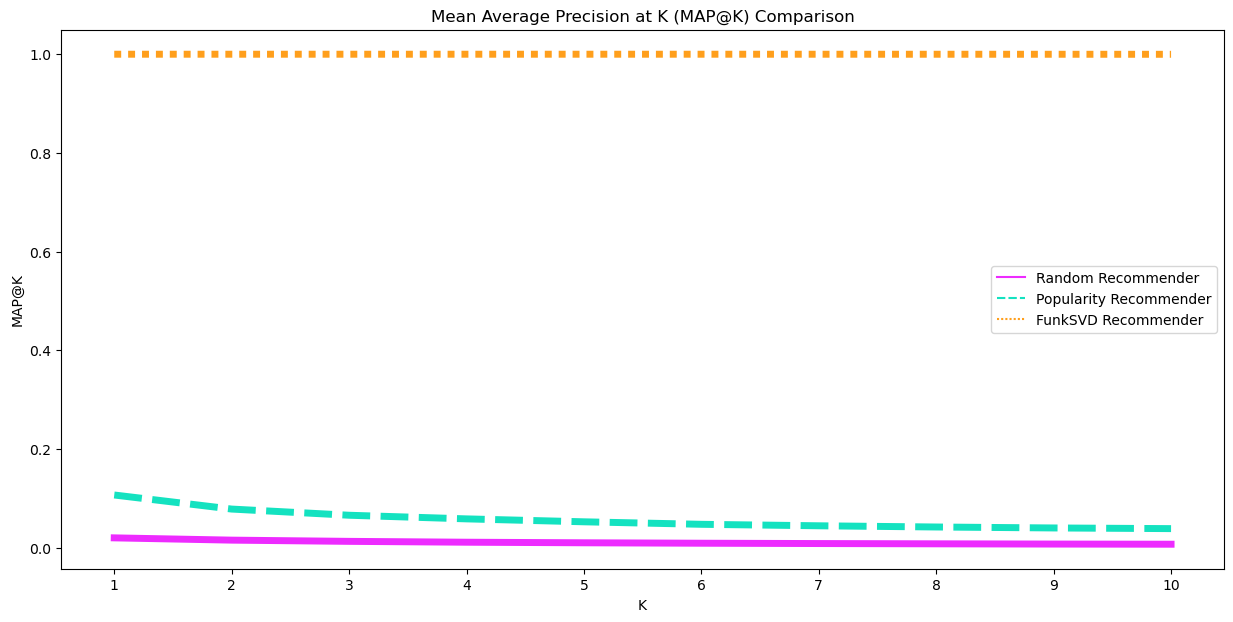

In [83]:
mapk_scores = [random_mapk, pop_mapk, svd_mapk]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'FunkSVD Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

### Coverage

% of items in the training set that the model recommended to the test users

The random recommendation has the highest coverage, with FunkSVD close behind it. Popularity has the worst coverage, which is intuitive, since it only recommends the top 10 items in the catalog.

In [84]:
# N=5877 observed recommendation lists
catalog = df.product_id.unique().tolist()
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 5877)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 5877)
svd_cat_coverage = recmetrics.catalog_coverage(svd_recs, catalog, 5877)

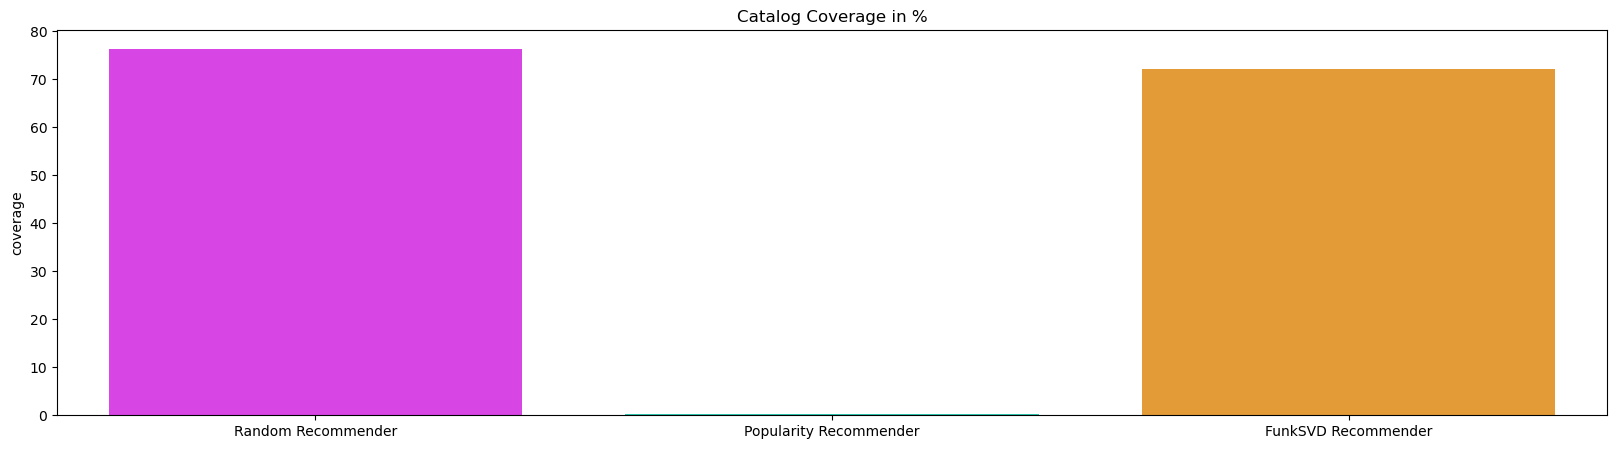

In [85]:
# plot of prediction coverage
coverage_scores = [random_cat_coverage,pop_cat_coverage,svd_cat_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'FunkSVD Recommender']

fig = plt.figure(figsize=(20, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

### Personalization

Personalization, in the recmetrics implementation, is calculated as 1 - average cosine similarity between different user's recommendations. We pass in the entire list of top 10 recommendations to recmetrics personalization, and we receive a personalization score. 

The higher the value of the score, the more personalized the recommendations are. 

As you can tell, the FunkSVD recommender is far more personalized than the popularity recommender. This makes sense, because all recommendations are identical in a popularity recommendation. 

In [86]:
personalization_list  = comp_df['svd_predictions'].to_list()
svd_personalization_score = recmetrics.personalization(predicted=personalization_list)

In [87]:
# pop
pop_personalization = comp_df['pop_predictions'].to_list()
pop_personalization_score = recmetrics.personalization(predicted=pop_personalization)

In [88]:
print('Personalization Scores:')
print(f'Popularity Recommender: {pop_personalization_score}')
print(f'FunkSVD Recommender: {svd_personalization_score}')

Personalization Scores:
Popularity Recommender: 1.1102230246251565e-16
FunkSVD Recommender: 0.9508808150030037


### Next Steps

If we are satisfied with the results of the model evaluation process, we would then retrain on the entire dataset and begin preparing the model for production. At some point in the process, the system will need to reunite the numeric product_ids and customer_ids with the original stock codes and customer ids.

There are many considerations when deploying a recommendation system to a production environment or live website.

Example Considerations:
- Where should the model reside?
    - Online - real time predictions? Near-Online? Offline?
- How often should the model receive new data and be retrained? 
    - Hourly? Daily? Weekly?
- What metrics do we want to track in the production environment to understand model performance?
    - Clicks, Add To Cart Actions, Purchases, Time on Page, Add to Wishlist, etc
- Do we want to create an A/B testing experiment for this recommender system? 
    - How does it perform against existing system with real users?

### Opportunities for Further Work
- Hybrid Recommenders are common practice to make up for the limitations of different kinds of recommender algorithms. We could explore a hybrid recommender or ensemble recommender to improve our performance.
- Evaluate the 'rating' feature we engineered at the beginning of the project. This decision assumed that price and quantity should hold equal value.
    - Is this a fair assumption? Or should price and quantity be weighted differently in the calculation?
    - Along with this, is it meaningful to add 'repeat purchase' as a value within the 'rating' feature? A repeat purchase on an item could indicate stronger preference for that item.
    - What if the customer returns the item? A return would clearly indicate a negative preference toward the item. 
- Explore other recommendation algorithms, such as K Nearest Neighbors or Restricted Boltzmann Machines


### Conclusion

Recommendation systems can be a powerful machine learning technique to unite customers with products that they want. This project has just scratched the surface of these systems. There are likely hundreds or thousands of different algorithm variations and combinations to address the recommendation problem. And even after discovering an algorithm that works for your organization, you must deploy the model in a way that fits the constraints of your systems and meets your needs.

Thank you for taking the time to view this project. If you have any questions, please feel free to reach out on LinkedIn or my website below.

If you have any feedback, I would happy to hear it! I am always looking to learn more about the field of machine learning and data science.

#### Check out more of my data analysis projects and work at:

__Website__ https://benjaminwyndham.com/

__LinkedIn__ https://www.linkedin.com/in/benwyndham/

__GitHub__ https://github.com/bwyndham